In [8]:
import torch
import torch.nn as nn
import sqlite3
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import importlib
import student_transformer
importlib.reload(student_transformer)
from student_transformer import StudentTransformer
from data_loader import StudentPerformanceDataset, collate_fn
from torch.utils.data import DataLoader

# Константы
SEQ_LEN = 8
DEVICE = torch.device("cuda")
print(f"Используем устройство: {DEVICE}")

Используем устройство: cuda


In [9]:
dataset = StudentPerformanceDataset(db_path="school.db", seq_len=8)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)

print(f"Количество последовательностей: {len(dataset)}")
print(f"Пример батча:")
for batch in dataloader:
    print("subject.shape:", batch["subject"].shape)
    print("numeric.shape:", batch["numeric"].shape)
    print("target.shape:", batch["target"].shape)
    break

✅ Загружено 240000 последовательностей (train)
Количество последовательностей: 240000
Пример батча:
subject.shape: torch.Size([64, 8])
numeric.shape: torch.Size([64, 8, 3])
target.shape: torch.Size([64])


In [11]:
model = StudentTransformer(
    num_subjects=5,
    num_absence_reasons=6,   # ← обязательно 6!
    num_club_types=2,
    numeric_features=3,
    embed_dim=64,
    num_heads=4,
    num_layers=2,
    pred_type="binary"
)

print("✅ Модель создана")
print("Число параметров:", sum(p.numel() for p in model.parameters()))

✅ Модель создана
Число параметров: 565633


In [12]:
# === Ячейка: Обучение с валидацией и метриками ===

import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Загрузка данных
from data_loader import StudentPerformanceDataset, collate_fn
from torch.utils.data import DataLoader

train_dataset = StudentPerformanceDataset(split="train")
test_dataset = StudentPerformanceDataset(split="test")  # используем как val

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

# Настройка модели
device = torch.device("cuda")
model.to(device)

# Используем BCELoss (предполагаем, что в модели есть Sigmoid)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Обучение
model.train()
train_losses = []
val_losses = []
val_metrics = []

print(f"{'Эпоха':<5} {'Train Loss':<10} {'Val Loss':<10} {'Acc':<7} {'Prec':<7} {'Rec':<7} {'F1':<7} {'Время':<6}")
print("-" * 70)

for epoch in range(10):
    start_time = time.time()
    
    # --- Обучение ---
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        optimizer.zero_grad()
        outputs = model(batch)
        loss = criterion(outputs, batch["target"])
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    
    # --- Валидация ---
    model.eval()
    val_loss = 0.0
    all_preds, all_targets = [], []
    
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(batch)
            loss = criterion(outputs, batch["target"])
            val_loss += loss.item()
            
            # Собираем предсказания (уже вероятности, т.к. BCELoss + Sigmoid)
            all_preds.extend(outputs.cpu().numpy())
            all_targets.extend(batch["target"].cpu().numpy())
    
    avg_val_loss = val_loss / len(val_loader)
    
    # Применяем порог 0.5 (можно изменить)
    all_preds_bin = (np.array(all_preds) > 0.5).astype(int)
    all_targets = np.array(all_targets)
    
    # Метрики
    acc = accuracy_score(all_targets, all_preds_bin)
    prec = precision_score(all_targets, all_preds_bin, zero_division=0)
    rec = recall_score(all_targets, all_preds_bin, zero_division=0)
    f1 = f1_score(all_targets, all_preds_bin, zero_division=0)
    
    # Сохраняем
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_metrics.append({'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1})
    
    # Вывод
    epoch_time = time.time() - start_time
    print(f"{epoch+1:<5} {avg_train_loss:<10.4f} {avg_val_loss:<10.4f} "
          f"{acc:<7.4f} {prec:<7.4f} {rec:<7.4f} {f1:<7.4f} {epoch_time:<6.1f}s")

# Сохранение модели
torch.save(model.state_dict(), "student_transformer.pth")
print("\n✅ Модель сохранена")

✅ Загружено 240000 последовательностей (train)
✅ Загружено 60000 последовательностей (test)
Эпоха Train Loss Val Loss   Acc     Prec    Rec     F1      Время 
----------------------------------------------------------------------
1     0.3663     0.3249     0.8558  0.7560  0.4285  0.5470  30.6  s
2     0.3307     0.3207     0.8580  0.7003  0.5258  0.6007  30.0  s
3     0.3272     0.3210     0.8584  0.7163  0.5011  0.5897  29.6  s
4     0.3253     0.3211     0.8583  0.7175  0.4991  0.5887  29.7  s
5     0.3242     0.3228     0.8581  0.7038  0.5204  0.5984  29.7  s
6     0.3229     0.3240     0.8558  0.7571  0.4269  0.5459  29.8  s
7     0.3228     0.3202     0.8579  0.7247  0.4845  0.5807  32.1  s
8     0.3215     0.3237     0.8588  0.7281  0.4865  0.5832  29.6  s
9     0.3210     0.3208     0.8599  0.7260  0.4980  0.5908  29.6  s
10    0.3206     0.3202     0.8586  0.7295  0.4825  0.5809  29.5  s

✅ Модель сохранена


In [13]:
# Загрузка тестовых данных
test_dataset = StudentPerformanceDataset(split="test")
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

# Оценка
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(batch)
        all_preds.extend(outputs.cpu().numpy())
        all_targets.extend(batch["target"].cpu().numpy())

# Метрики
preds_binary = (np.array(all_preds) > 0.5).astype(int)
targets = np.array(all_targets)

print(f"Accuracy: {accuracy_score(targets, preds_binary):.4f}")
print(f"F1-score: {f1_score(targets, preds_binary):.4f}")
print(f"AUC-ROC:  {roc_auc_score(targets, all_preds):.4f}")

✅ Загружено 60000 последовательностей (test)
Accuracy: 0.8586
F1-score: 0.5809
AUC-ROC:  0.8884


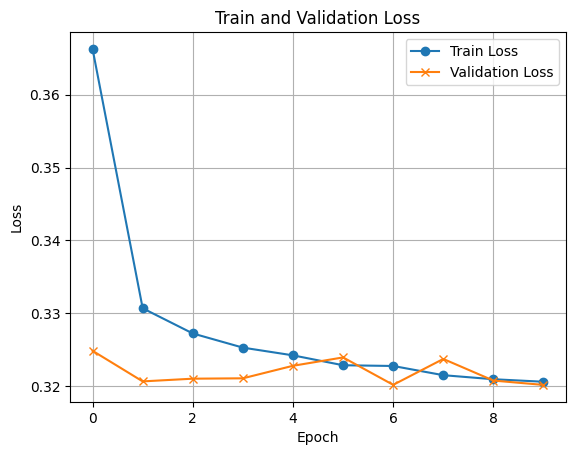

In [16]:
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(val_losses, label="Validation Loss", marker='x')
plt.title("Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()  # Легенда, чтобы отличать train и validation
plt.grid(True)
plt.show()

In [18]:
# === Ячейка: Пример предсказания (инференс) ===

# 1. Загрузим сохранённую модель
model.load_state_dict(torch.load("student_transformer.pth", map_location=device))
model.eval()

# 2. Подготовим пример данных (8 недель по математике)
# Формат: [неделя 1, неделя 2, ..., неделя 8]
example_data = {
    "subject": "literature",
    "grades": [4.5, 4.0, 4.0, 3.5, 3.0, 3.0, 2.5, 3.0],        # оценки падают
    "attendance": [1, 1, 1, 0, 0, 1, 1, 1],                      # пропуски на 4-5 неделях
    "club_attended": [1, 1, 0, 0, 0, 0, 0, 0],                   # перестал ходить в кружок
    "absence_reasons": [None, None, None, "illness", "illness", None, None, None]
}

# 3. Преобразуем в формат модели
SUBJECT_TO_ID = {"math":0, "russian":1, "physics":2, "literature":3, "biology":4}
REASON_TO_ID = {None:0, "illness":1, "competition":2, "family":3, "other":4, "camp":5}

subject_id = SUBJECT_TO_ID[example_data["subject"]]
absence_ids = [REASON_TO_ID.get(r, 4) for r in example_data["absence_reasons"]]
numeric = np.stack([
    example_data["grades"],
    example_data["attendance"],
    example_data["club_attended"]
], axis=1).astype(np.float32)

# Создаём батч из одного примера
batch = {
    "subject": torch.tensor([[subject_id] * 8]),      # [1, 8]
    "absence": torch.tensor([absence_ids]),           # [1, 8]
    "club": torch.tensor([example_data["club_attended"]]),  # [1, 8]
    "numeric": torch.tensor([numeric])                # [1, 8, 3]
}

# 4. Предсказание
with torch.no_grad():
    prob = model({k: v.to(device) for k, v in batch.items()}).item()

# 5. Вывод
print(f"🎓 Прогноз для ученика по предмету '{example_data['subject']}':")
print(f"   Вероятность снижения успеваемости: {prob:.2%}")
if prob > 0.5:
    print("   ⚠️  Рекомендуется педагогическое вмешательство!")
else:
    print("   ✅ Риск низкий.")

🎓 Прогноз для ученика по предмету 'literature':
   Вероятность снижения успеваемости: 1.89%
   ✅ Риск низкий.
